In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az

from arviz.utils import Numba
Numba.disable_numba()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Bài 5 - Thống kê Bayes tính toán (Computational Bayesian Statistics)

**THỐNG KÊ MÁY TÍNH VÀ ỨNG DỤNG (CLC)**

*(Vũ Quốc Hoàng, FIT - HCMUS, vqhoang@fit.hcmus.edu.vn)*

## Chủ đề

1. Một số thư viện Python hỗ trợ phân tích dữ liệu Bayes: PyMC3 và ArviZ
2. Suy diễn Bayes

## Một số thư viện Python hỗ trợ phân tích dữ liệu Bayes

* [PyMC3](https://docs.pymc.io/en/v3/)
* [ArviZ](https://arviz-devs.github.io/arviz/)

## Suy diễn Bayes

### Ví dụ 1

In [2]:
mu = np.array([1.0, 2.0, 3.0, 4.0])
prior = 1/4 * np.ones(len(mu))
x = np.array([1.77, 2.23, 2.70])

def posterior(sigma2):
    likelihood = np.exp(-np.sum((x - np.reshape(mu, (-1, 1)))**2, axis=1)/(2*sigma2))
    likelihood_prior = likelihood * prior
    return likelihood_prior/np.sum(likelihood_prior)

In [3]:
sigma2 = [1, 1.35, 2]
pd.DataFrame({"$\sigma^2 = %.2f$" % s2: np.round(posterior(s2), 4) for s2 in sigma2},
             index=["$P(\mu= %.1f|D)$" % m for m in mu])

,$\sigma^2 = 1.00$,$\sigma^2 = 1.35$,$\sigma^2 = 2.00$
$P(\mu= 1.0|D)$,0.0706,0.1100,0.1583
$P(\mu= 2.0|D)$,0.6369,0.5612,0.4754
$P(\mu= 3.0|D)$,0.2862,0.3103,0.3187
$P(\mu= 4.0|D)$,0.0064,0.0186,0.0477


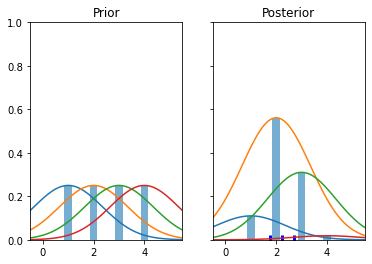

In [4]:
def plot_prior_post(sigma2):
    x_min, x_max = np.min(mu) - 1.5, np.max(mu) + 1.5
    t = np.linspace(x_min, x_max, 100)
    _, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    ax1.set_title("Prior")
    ax1.bar(mu, prior, width=0.3, alpha=0.6)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0, 1)
    for i in range(len(mu)):
        norm_dist = stats.norm(mu[i], sigma2)
        ax1.plot(t, prior[i]/norm_dist.pdf(mu[i]) * norm_dist.pdf(t))
    
    post = posterior(sigma2)
    
    ax2.set_title("Posterior")
    ax2.bar(mu, post, width=0.3, alpha=0.6)
    ax2.set_xlim(x_min, x_max)
    for i in range(len(mu)):
        norm_dist = stats.norm(mu[i], sigma2)
        ax2.plot(t, post[i]/norm_dist.pdf(mu[i]) * norm_dist.pdf(t))
    ax2.scatter(x, np.zeros(len(x)), s=100, marker='|', color='b', linewidths=3)
    
    #plt.tight_layout()
    #plt.savefig("BayesInf_example1.pdf")
    
    plt.show()
    
plot_prior_post(1.35)

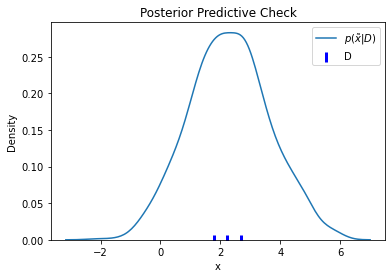

In [5]:
def posterior_predictive_check(sigma2, N):
    post = posterior(sigma2)
    mu_post_sample = np.random.choice(mu, size=N, p=post)
    x_post_sample = np.random.normal(mu_post_sample, np.sqrt(sigma2), size=N)
    sns.kdeplot(x_post_sample, label="$p(\\tilde{x}|D)$")
    plt.scatter(x, np.zeros(len(x)), s=100, marker='|', color='b', linewidths=3, label="D")
    plt.legend()
    plt.title("Posterior Predictive Check")
    plt.xlabel("x")
    
    #plt.tight_layout()
    #plt.savefig("BayesInf_example1_PPC.pdf")
    
    plt.show()
    
posterior_predictive_check(1.35, 1000)

#### PyMC3

In [6]:
mu = np.array([1.0, 2.0, 3.0, 4.0])
prior = 1/4 * np.ones(len(mu))
x = np.array([1.77, 2.23, 2.70])
sigma2 = 1.35

with pm.Model() as model:
    mu_index_var = pm.Categorical("mu_index", p=prior)
    mu_var = theano.shared(mu)[mu_index_var]
    x_var = pm.Normal("x", mu=mu_var, tau=1/sigma2, observed=x)
    trace = pm.sample(1000, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
CategoricalGibbsMetropolis: [mu_index]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.


[1. 2. 3. 4.]
[0.101 0.564 0.32  0.015]


D:\Anaconda\lib\site-packages\pymc3\sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


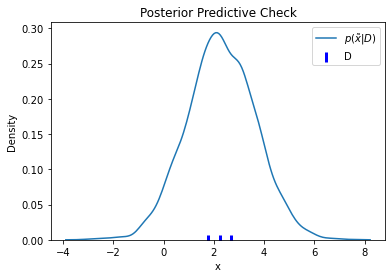

In [7]:
mu_index_posterior = trace["mu_index"]
values, counts = np.unique(mu_index_posterior, return_counts=True)
print(mu[values])
print(counts/np.sum(counts))
x_post_sample = pm.sample_posterior_predictive(trace, 1000, model)["x"].flatten()

sns.kdeplot(x_post_sample, label="$p(\\tilde{x}|D)$")
plt.scatter(x, np.zeros(len(x)), s=100, marker='|', color='b', linewidths=3, label="D")
plt.legend()
plt.title("Posterior Predictive Check")
plt.xlabel("x")

#plt.tight_layout()
#plt.savefig("BayesInf_example1_PPC_PyMC3.pdf")

plt.show()

### Ví dụ 2

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


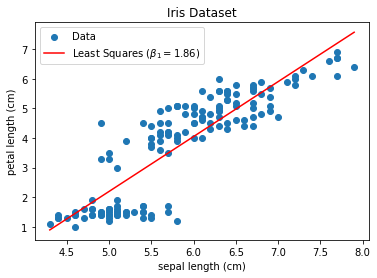

In [8]:
from sklearn import datasets

iris = datasets.load_iris()
print(iris.feature_names)

x = iris.data[:, 0]
y = iris.data[:, 2]

res = stats.linregress(x, y)
t = np.linspace(min(x), max(x), 100)
y_linreg = res.intercept + res.slope*t

plt.scatter(x, y, label="Data")
plt.plot(t, y_linreg, color="red", label=r"Least Squares ($\beta_1 = %.2f$)" % res.slope)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Iris Dataset")
plt.legend()

#plt.tight_layout()
#plt.savefig("BayesInf_example2_Iris.pdf")

plt.show()

#### PyMC3

In [9]:
with pm.Model() as model:
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", lower=0, upper=1000)
    y_hat = beta_0 + beta_1*x
    y_var = pm.Normal("y", mu=y_hat, sigma=sigma, observed=y)
    trace = pm.sample(5000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_1, beta_0]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 100 seconds.


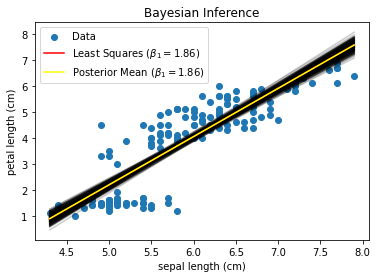

In [10]:
N = len(trace["beta_0"])
for i in np.random.randint(0, N, size=200):
    plt.plot(t, trace["beta_0"][i] + trace["beta_1"][i]*t, color="black", alpha=0.2)
    
plt.scatter(x, y, label="Data")
plt.plot(t, y_linreg, color="red", label=r"Least Squares ($\beta_1 = %.2f$)" % res.slope)
plt.plot(t, np.mean(trace["beta_0"]) + np.mean(trace["beta_1"])*t, color="yellow", 
         label=r"Posterior Mean ($\beta_1 = %.2f$)" % np.mean(trace["beta_1"]))
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Bayesian Inference")
plt.legend()

#plt.tight_layout()
#plt.savefig("BayesInf_example2_Posterior.pdf")

plt.show()

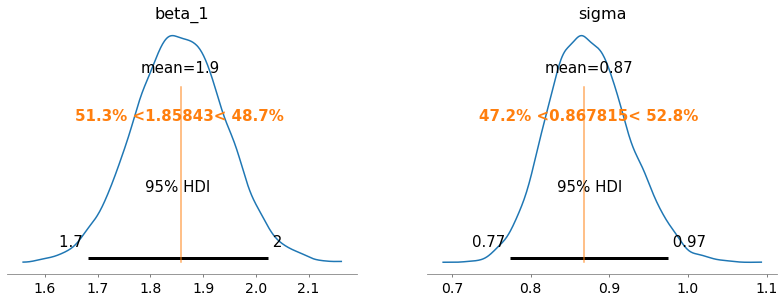

In [11]:
SS_res = np.sum((y - (res.intercept + res.slope*x))**2)
sigma_res = np.sqrt(SS_res/(len(y) - 2))
with model:
    az.plot_posterior(trace, var_names=["beta_1", "sigma"], hdi_prob=0.95, ref_val=[res.slope, sigma_res])
    
    #plt.tight_layout()
    #plt.savefig("BayesInf_example2_Posterior2.pdf")
    
    plt.show()

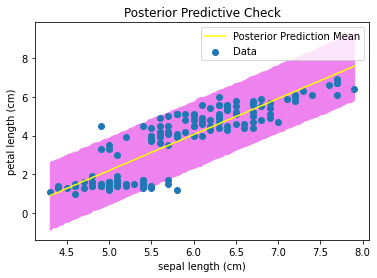

In [12]:
x_test = np.linspace(min(x), max(x), 100)
y_hat_pred = trace["beta_0"] + trace["beta_1"]*x_test.reshape((-1,1))
y_pred = np.random.normal(y_hat_pred, trace["sigma"])
anpha = 0.05
lower_pred = np.quantile(y_pred, anpha/2, axis=1)
upper_pred = np.quantile(y_pred, 1 - anpha/2, axis=1)
mean_pred = np.mean(y_pred, axis=1)

plt.fill_between(x_test, lower_pred, upper_pred, color="violet")
plt.plot(x_test, mean_pred, color="yellow", label="Posterior Prediction Mean")
plt.scatter(x, y, label="Data")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Posterior Predictive Check")
plt.legend()

#plt.tight_layout()
#plt.savefig("BayesInf_example2_PPC.pdf")

plt.show()

## Mô hình nhị thức

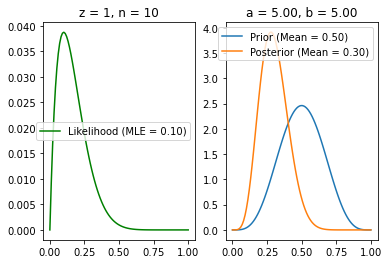

In [13]:
a, b = 5, 5
z, n = 1, 10

theta = np.linspace(0, 1, 100)
likelihood = theta**z * (1 - theta)**(n - z)
prior_dist = stats.beta(a, b)
posterior_dist = stats.beta(a + z, b + n - z)
prior = prior_dist.pdf(theta)
posterior = posterior_dist.pdf(theta)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(theta, likelihood, color="g", label="Likelihood (MLE = %.2f)" % (z/n))
ax1.set_title("z = %d, n = %d" % (z, n))
ax1.legend()
ax2.plot(theta, prior, label="Prior (Mean = %.2f)" % prior_dist.mean())
ax2.plot(theta, posterior, label="Posterior (Mean = %.2f)" % posterior_dist.mean())
ax2.set_title("a = %.2f, b = %.2f" % (a, b))
ax2.legend()

#plt.tight_layout()
#plt.savefig("BinModel_Beta.pdf")

plt.show()

#### PyMC3

In [14]:
with pm.Model() as model:
    theta = pm.Beta("theta", alpha=a, beta=b)
    z_var = pm.Binomial("z", p=theta, n=n, observed=z)
    trace = pm.sample(5000, return_inferencedata=False)
    prior_pred = pm.sample_prior_predictive()
    posterior_pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 88 seconds.
The acceptance probability does not match the target. It is 0.8812042829938157, but should be close to 0.8. Try to increase the number of tuning steps.


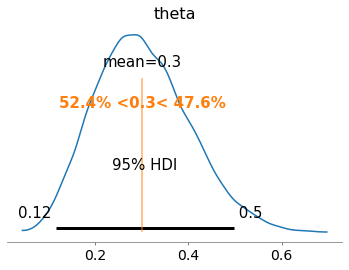

In [15]:
with model:
    az.plot_posterior(trace, var_names=["theta"], hdi_prob=0.95, ref_val=posterior_dist.mean())
    
    #plt.tight_layout()
    #plt.savefig("BinModel_Posterior.pdf")
    
    plt.show()

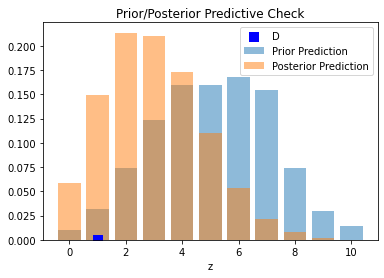

In [16]:
prior_values, prior_counts = np.unique(prior_pred["z"], return_counts=True)
posterior_values, posterior_counts = np.unique(posterior_pred["z"], return_counts=True)

plt.bar(prior_values, prior_counts/len(prior_pred["z"]), label="Prior Prediction", alpha=0.5)
plt.bar(posterior_values, posterior_counts/len(posterior_pred["z"]), label="Posterior Prediction", alpha=0.5)
plt.scatter(z, 0, s=100, marker='|', color='b', linewidths=10, label="D")
plt.legend()
plt.title("Prior/Posterior Predictive Check")
plt.xlabel("z")

#plt.tight_layout()
#plt.savefig("BinModel_PPC.pdf")

plt.show()

## “Tính” phân phối hậu nghiệm

### Phân phối tiên nghiệm liên hợp

[Conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior)

### Xấp xỉ lưới

In [17]:
def local_max(x):
    local_max = []
    inc = True
    for i in range(len(x) - 1):
        if inc and x[i + 1] < x[i]:
            local_max.append(i)
            inc = False
        elif not inc and x[i + 1] > x[i]:
            inc = True
    return local_max

Mô hình nhị thức với phân phối tiên nghiệm 2 đỉnh (mode) dùng “xấp xỉ lưới”

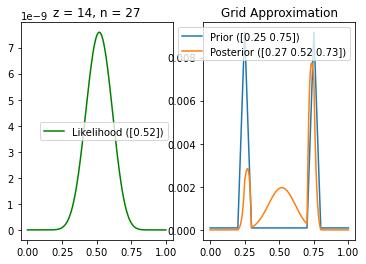

In [18]:
#z, n = 1, 10
z, n = 14, 27

theta = np.linspace(0, 1, 1000) # 1000-points grid

likelihood = theta**z * (1 - theta)**(n - z)
mle = np.round(theta[local_max(likelihood)], 2)

prior = np.concatenate((np.repeat(1,200), np.linspace(1, 100, 50), np.linspace(100, 1, 50), np.repeat(1, 200),
                        np.repeat(1, 200), np.linspace(1, 100, 50), np.linspace(100, 1, 50), np.repeat(1, 200)))
#prior = np.concatenate((np.linspace(1, 500, 500), np.linspace(500, 1, 500)))
prior = prior/np.sum(prior)
prior_modes = np.round(theta[local_max(prior)], 2)

posterior = likelihood * prior
posterior = posterior/np.sum(posterior)
posterior_modes = np.round(theta[local_max(posterior)], 2)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(theta, likelihood, color="g", label=f"Likelihood ({mle})")
ax1.set_title("z = %d, n = %d" % (z, n))
ax1.legend()
ax2.plot(theta, prior, label=f"Prior ({prior_modes})")
ax2.plot(theta, posterior, label=f"Posterior ({posterior_modes})")
ax2.set_title("Grid Approximation")
ax2.legend()

#plt.tight_layout()
#plt.savefig("GridApprox.pdf")

plt.show()

### Lấy mẫu loại bỏ

In [19]:
# Algorithm ERS
# Input:
#   N: output sequence length
#   f: the non-normalised target density
#   gs: sampler for the proposal density
#   g: the proposal density
#   c > 0: such that f(x) <= c g(x) for all x
# Output: a tuple (X, T)
#   X: sequence X1, X2, X3, . . . iid with density f tiddle
#   T: total number of proposals
def ESR(N, f, gs, g, c):
    T = 0
    X = []
    i = 0
    while i < N:
        T = T + 1
        Xn = gs()
        Un = np.random.uniform(size=1)
        if c*g(Xn)*Un <= f(Xn):
            i = i + 1
            X.append(Xn)

    return (np.array(X), T)

Acceptance rate (Z): 0.5721
Mean: 0.7150834466451815
Variance: 0.628833583272315


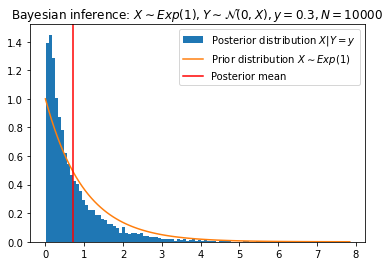

In [20]:
np.random.seed(2022)

N = 10000
y = 0.3

f = lambda x: 1/np.sqrt(x) * np.exp(-y**2/(2*x) - x) * (1 if x > 0 else 0)
gs = lambda: np.random.exponential(size=1)
g = lambda x: np.exp(-x)
c = 1/np.abs(y) * np.exp(-1/2)

x, T = ESR(N, f, gs, g, c)
print("Acceptance rate (Z):", round(N/T, 4))
print("Mean:", np.mean(x))
print("Variance:", np.var(x, ddof=1))

t = np.linspace(0, np.max(x), num=100)

plt.hist(x, bins=100, density=True, label="Posterior distribution $X|Y=y$")
plt.plot(t, stats.expon.pdf(t), label=r"Prior distribution $X \sim Exp(1)$")
plt.axvline(x=np.mean(x), color="red", label="Posterior mean")
plt.legend()
plt.title("Bayesian inference: $X \sim Exp(1), Y \sim \mathcal{N}(0, X),$" + "$y = {0}, N = {1}$".format(y, N))

#plt.tight_layout()
#plt.savefig("Bayes_1.pdf")

plt.show()

Acceptance rate (Z): 0.3458
Mean: 1.951797830036798
Variance: 1.2603030367570411


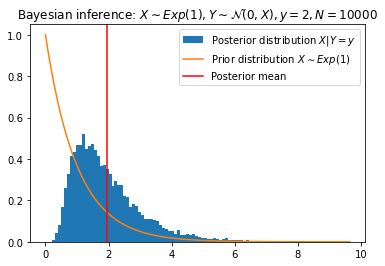

In [21]:
np.random.seed(2022)

N = 10000
y = 2

f = lambda x: 1/np.sqrt(x) * np.exp(-y**2/(2*x) - x) * (1 if x > 0 else 0)
gs = lambda: np.random.exponential(size=1)
g = lambda x: np.exp(-x)
c = 1/np.abs(y) * np.exp(-1/2)

x, T = ESR(N, f, gs, g, c)
print("Acceptance rate (Z):", round(N/T, 4))
print("Mean:", np.mean(x))
print("Variance:", np.var(x, ddof=1))

t = np.linspace(0, np.max(x), num=100)

plt.hist(x, bins=100, density=True, label="Posterior distribution $X|Y=y$")
plt.plot(t, stats.expon.pdf(t), label=r"Prior distribution $X \sim Exp(1)$")
plt.axvline(x=np.mean(x), color="red", label="Posterior mean")
plt.legend()
plt.title("Bayesian inference: $X \sim Exp(1), Y \sim \mathcal{N}(0, X),$" + "$y = {0}, N = {1}$".format(y, N))

#plt.tight_layout()
#plt.savefig("Bayes_2.pdf")

plt.show()

#### PyMC3

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 43 seconds.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.


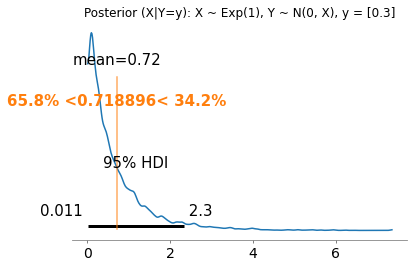

In [22]:
y = [0.3]

with pm.Model() as model:
    x = pm.Exponential("x", lam=1)
    y_var = pm.Normal("y", mu=0, tau=1/x, observed=y)
    trace = pm.sample(5000, return_inferencedata=False)
    axes = az.plot_posterior(trace, var_names=["x"], hdi_prob=0.95, ref_val=np.mean(trace["x"]))
    axes.set_title("Posterior (X|Y=y): X ~ Exp(1), Y ~ N(0, X), " + f"y = {y}")
    #plt.tight_layout()
    #plt.savefig("RejSamp_Post1.pdf")
    plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 44 seconds.


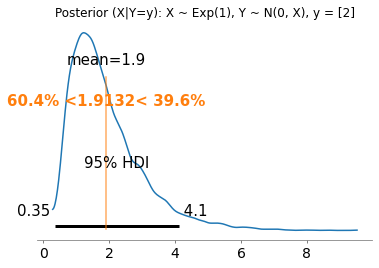

In [23]:
y = [2]

with pm.Model() as model:
    x = pm.Exponential("x", lam=1)
    y_var = pm.Normal("y", mu=0, tau=1/x, observed=y)
    trace = pm.sample(5000, return_inferencedata=False)
    axes = az.plot_posterior(trace, var_names=["x"], hdi_prob=0.95, ref_val=np.mean(trace["x"]))
    axes.set_title("Posterior (X|Y=y): X ~ Exp(1), Y ~ N(0, X), " + f"y = {y}")
    #plt.tight_layout()
    #plt.savefig("RejSamp_Post2.pdf")
    plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 54 seconds.


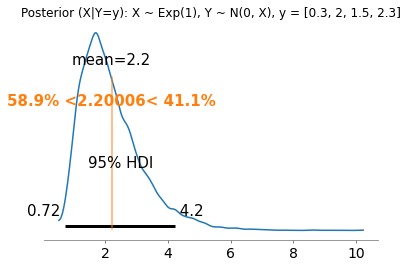

In [24]:
y = [0.3, 2, 1.5, 2.3]

with pm.Model() as model:
    x = pm.Exponential("x", lam=1)
    y_var = pm.Normal("y", mu=0, tau=1/x, observed=y)
    trace = pm.sample(5000, return_inferencedata=False)
    posterior_pred = pm.sample_posterior_predictive(trace)
    axes = az.plot_posterior(trace, var_names=["x"], hdi_prob=0.95, ref_val=np.mean(trace["x"]))
    axes.set_title("Posterior (X|Y=y): X ~ Exp(1), Y ~ N(0, X), " + f"y = {y}")
    #plt.tight_layout()
    #plt.savefig("RejSamp_Post3.pdf")
    plt.show()

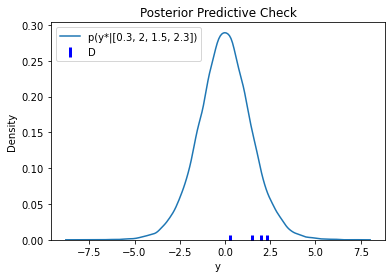

In [25]:
y_post_sample = posterior_pred["y"].flatten()

sns.kdeplot(y_post_sample, label=f"p(y*|{y})")
plt.scatter(y, np.zeros(len(y)), s=100, marker='|', color='b', linewidths=3, label="D")
plt.legend()
plt.title("Posterior Predictive Check")
plt.xlabel("y")
#plt.tight_layout()
#plt.savefig("RejSamp_Post3_PPC.pdf")
plt.show()

## Markov chain Monte Carlo

### Thuật toán Metropolis-Hastings

In [26]:
def MH_Example1(N, X0=0):
    X = [X0]
    Xn = X0
    for _ in range(N):
        Xp = Xn + np.random.choice([-1, 1])
        if np.random.uniform() <= 2.0**(abs(Xn) - abs(Xp)):
            Xn = Xp
        X.append(Xn)
    return np.array(X)

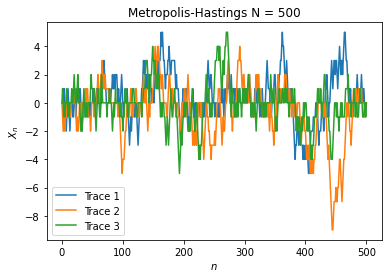

In [27]:
N = 500
traces = [MH_Example1(N, X0=0) for _ in range(3)]

for i, trace in enumerate(traces):
    plt.plot(range(N + 1), trace, label=f"Trace {i + 1}")
plt.legend()
plt.xlabel("$n$")
plt.ylabel("$X_n$")
plt.title(f"Metropolis-Hastings N = {N}")
#plt.tight_layout()
#plt.savefig("MH_Example1_Trace500.pdf")
plt.show()

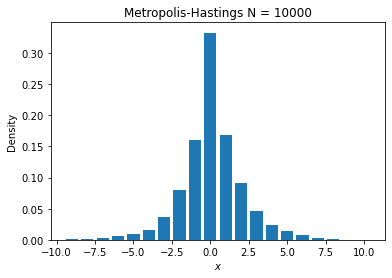

In [28]:
N = 10000
trace = MH_Example1(N, X0=0)
values, counts = np.unique(trace, return_counts=True)

plt.bar(values, counts/N)
plt.title(f"Metropolis-Hastings N = {N}")
plt.xlabel("$x$")
plt.ylabel("Density")
#plt.tight_layout()
#plt.savefig("MH_Example1_Density.pdf")
plt.show()

#### Thuật toán bước ngẫu nhiên Metropolis

In [29]:
def RW_MEtropolis(N, f, sigma, X0):
    X = [X0]
    Xn = X0
    for _ in range(N):
        ep = np.random.normal(0, sigma)
        Xp = Xn + ep
        if np.random.uniform() <= min(1, f(Xp)/f(Xn)):
            Xn = Xp
        X.append(Xn)
    return np.array(X)

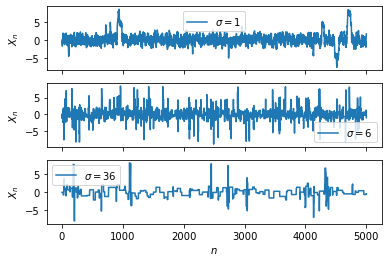

In [30]:
def f(x):
    return math.sin(x)**2/(x**2) * (-3*math.pi <= x <= 3*math.pi)

N = 5000
sigmas = [1, 6, 36]
traces = [RW_MEtropolis(N, f, s2, 0.001) for s2 in sigmas]

_, axs = plt.subplots(len(traces), 1, sharex=True)
for i, trace in enumerate(traces):
    axs[i].plot(range(N + 1), trace, label=f"$\sigma = {sigmas[i]}$")
    axs[i].set_ylabel("$X_n$")
    axs[i].legend()
plt.xlabel("$n$")
#plt.tight_layout()
#plt.savefig("RWM_Example_Trace.pdf")
plt.show()

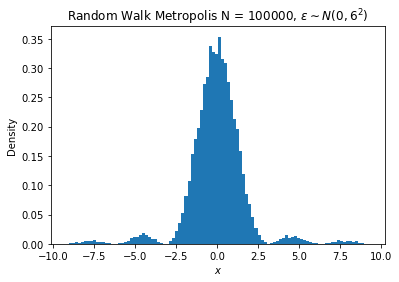

In [31]:
N = 100000
sigma= 6
trace = RW_MEtropolis(N, f, sigma, 0.001)

plt.hist(trace, density=True, bins=100)
plt.title(f"Random Walk Metropolis N = {N}, $\epsilon \sim N(0, {sigma}^2)$")
plt.xlabel("$x$")
plt.ylabel("Density")
#plt.tight_layout()
#plt.savefig("RWM_Example_Density.pdf")
plt.show()

### Lấy mẫu Gibbs

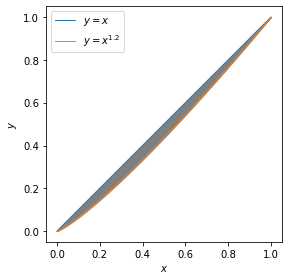

In [32]:
x = np.linspace(0, 1, 100)

plt.fill_between(x, x, x**1.2, color="gray")
plt.plot(x, x, linewidth=1, label="$y = x$")
plt.plot(x, x**1.2, linewidth=1, label="$y = x^{1.2}$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("Gibbs_Example.pdf")
plt.show()

In [33]:
def reject_uniform(N):
    xy = []
    T = 0
    i = 0
    while i < N:
        T = T + 1
        Xn, Yn = np.random.uniform(0, 1, size=2)
        if Xn**1.2 <= Yn <= Xn:
            i = i + 1
            xy.append((Xn, Yn))
    return (np.array(xy), T)

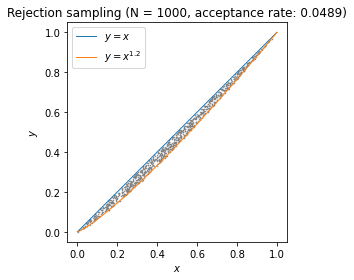

In [34]:
N = 1000
xy, T = reject_uniform(N)

plt.plot(x, x, linewidth=1, label="$y = x$")
plt.plot(x, x**1.2, linewidth=1, label="$y = x^{1.2}$")
plt.scatter(xy[:, 0], xy[:, 1], marker=".", s=1, color="gray")
plt.title(f"Rejection sampling (N = {N}, acceptance rate: {round(N/T, 4)})")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("Gibbs_RejecSamp.pdf")
plt.show()

In [35]:
def Gibbs_uniform(N):
    xy = []
    x, y = 0.5, 0.5
    for _ in range(N):
        x = np.random.uniform(y, y**(1/1.2))
        y = np.random.uniform(x**1.2, x)
        xy.append((x, y))
    return np.array(xy)

def get_partial_xy(xy, k):
    x, y = [xy[0, 0]], [xy[0, 1]]
    for i in range(1, k):
        x += [xy[i, 0], xy[i, 0]]
        y += [xy[i-1, 1], xy[i, 1]]
    return x, y

N = 1000
xy = Gibbs_uniform(N)

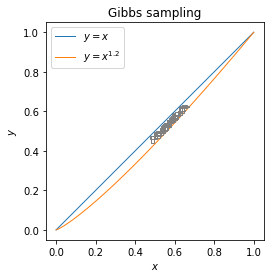

In [36]:
plt.plot(x, x, linewidth=1, label="$y = x$")
plt.plot(x, x**1.2, linewidth=1, label="$y = x^{1.2}$")
plt.plot(*get_partial_xy(xy, 100), color="gray", linewidth=1)
plt.title(f"Gibbs sampling")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.gca().set_aspect('equal')
#plt.tight_layout()
#plt.savefig("Gibbs_RejecSamp_Trace.pdf")
plt.show()

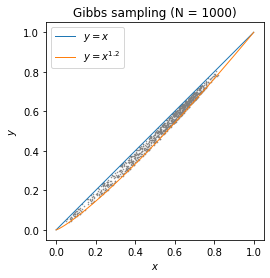

In [37]:
plt.plot(x, x, linewidth=1, label="$y = x$")
plt.plot(x, x**1.2, linewidth=1, label="$y = x^{1.2}$")
plt.scatter(xy[:, 0], xy[:, 1], marker=".", s=1, color="gray")
plt.title(f"Gibbs sampling (N = {N})")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.gca().set_aspect('equal')
#plt.tight_layout()
#plt.savefig("Gibbs_RejecSamp.pdf")
plt.show()

## Mô hình tuyến tính tổng quát

### Logistic Regression

['setosa' 'versicolor' 'virginica']


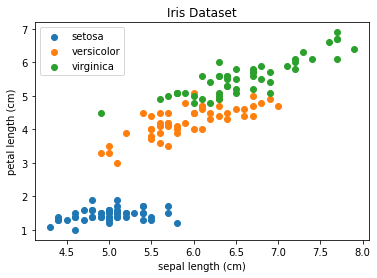

In [38]:
from sklearn import datasets

iris = datasets.load_iris()

x1 = iris.data[:, 0]
x2 = iris.data[:, 2]
X = np.column_stack((x1, x2))
y = iris.target
print(iris.target_names)

for c, c_name in enumerate(iris.target_names):
    plt.scatter(x1[y == c], x2[y == c], label=c_name)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Iris Dataset")
plt.legend()

#plt.tight_layout()
#plt.savefig("LogReg_Iris.pdf")

plt.show()

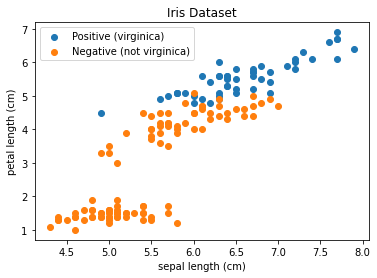

In [39]:
virginica_index = 2
y = (y == virginica_index)

plt.scatter(x1[y], x2[y], label=f"Positive ({iris.target_names[virginica_index]})")
plt.scatter(x1[np.logical_not(y)], x2[np.logical_not(y)], label=f"Negative (not {iris.target_names[virginica_index]})")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Iris Dataset")
plt.legend()

#plt.tight_layout()
#plt.savefig("LogReg_Iris2.pdf")

plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betaj, beta0]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 205 seconds.
The number of effective samples is smaller than 25% for some parameters.


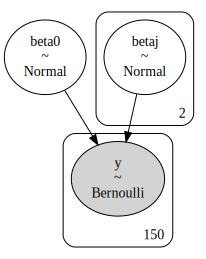

In [40]:
with pm.Model() as model:
    beta0 = pm.Normal('beta0', mu=0, sd=2)
    betaj = pm.Normal('betaj', mu=0, sd=2, shape=X.shape[1])
    p = pm.invlogit(beta0 + pm.math.dot(X, betaj))
    y_var = pm.Bernoulli('y', p, observed=y)
    trace = pm.sample(5000, return_inferencedata=False)
    
pm.model_to_graphviz(model)

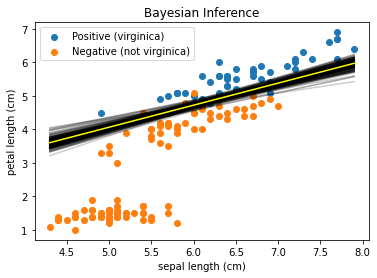

In [41]:
t = np.linspace(np.min(x1), np.max(x1), 100)
N = len(trace["beta0"])
for i in np.random.randint(0, N, size=200):
    beta_0 = trace["beta0"][i]
    beta_1 = trace["betaj"][:, 0][i]
    beta_2 = trace["betaj"][:, 1][i]
    plt.plot(t, (-beta_0 - beta_1*t)/beta_2, color="black", alpha=0.2)
    
plt.scatter(x1[y], x2[y], label=f"Positive ({iris.target_names[virginica_index]})")
plt.scatter(x1[np.logical_not(y)], x2[np.logical_not(y)], label=f"Negative (not {iris.target_names[virginica_index]})")
plt.plot(t, (-np.mean(trace["beta0"]) - np.mean(trace["betaj"][:, 0])*t)/np.mean(trace["betaj"][:, 1]), color="yellow")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Bayesian Inference")
plt.legend()

#plt.tight_layout()
#plt.savefig("LogReg_Iris_Posterior.pdf")

plt.show()

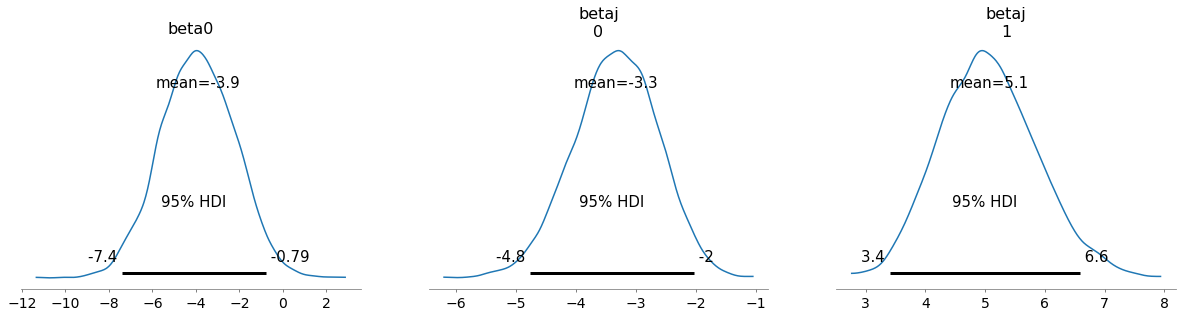

In [42]:
with model:
    az.plot_posterior(trace, var_names=["beta0", "betaj"], hdi_prob=0.95)
    
    #plt.tight_layout()
    #plt.savefig("LogReg_Iris_Posterior2.pdf")
    
    plt.show()

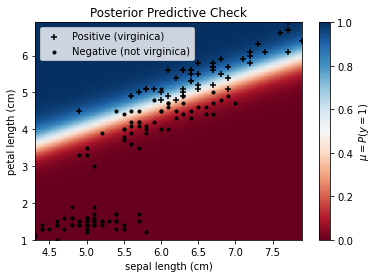

In [43]:
x1_test, x2_test = np.meshgrid(np.linspace(min(x1), max(x1), 50), np.linspace(min(x2), max(x2), 50))

z_pred = trace["beta0"] + trace["betaj"][:,0]*np.expand_dims(x1_test, 2) + trace["betaj"][:,1]*np.expand_dims(x2_test, 2)
y_prob_pred = np.mean(1/(1 + np.exp(-z_pred)), axis=2)

c = plt.pcolormesh(x1_test, x2_test, y_prob_pred, cmap="RdBu", vmin=0, vmax=1, shading="gouraud")
plt.colorbar(c, label="$\mu = P(y=1)$")
plt.scatter(x1[y], x2[y], marker="+", color="black",
            label=f"Positive ({iris.target_names[virginica_index]})")
plt.scatter(x1[np.logical_not(y)], x2[np.logical_not(y)], marker=".", color="black",
            label=f"Negative (not {iris.target_names[virginica_index]})")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.legend()
plt.title("Posterior Predictive Check")

#plt.tight_layout()
#plt.savefig("LogReg_Iris_PPC.pdf")

plt.show()